## I. Setting
### 1. Packages

In [1]:
# Import packages
import os, sys, shutil, warnings, random, glob, pylab, numpy as np, pandas as pd, time, datetime
from tqdm import tqdm

# packages for visualization
import pydicom, cv2, seaborn as sns, matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image
from imgaug import augmenters as iaa

# packages for model
import tensorflow as tf, keras
from keras.callbacks import EarlyStopping
from keras.backend.tensorflow_backend import set_session
from keras.models import load_model
from sklearn.model_selection import KFold, train_test_split

Using TensorFlow backend.


In [2]:
#### Package settings

# Display up to 50 columns of a pandas dataframe
pd.set_option('display.max_columns',50)
# ignore warnings
warnings.filterwarnings("ignore")


# Limit GPU usage to 80%
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=tf_config))

### 2. Directory

In [3]:
# The home directory of this project
root_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish'
# Ocean asset directories
# Image data
assets_image_data =('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/')
# Meta data (dataframe and array data)
assets_meta_data =('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/meta_data/')
# Visualization 
visual_DIR =('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets_visualization/')


# Sample data
sample_image=('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/')
# Sample image data directories for training using 
sample_train = ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_train/')
sample_validate = ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_validate/')
sample_test= ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_test/')

# Sample meta data (dataframe and array data)
sample_meta = ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/meta_data/sample_meta/')
# Sample visualization 
sample_visual=('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/visualization/sample_visual/')

#sample_dirs = ['sample_train','sample_validate','sample_test']
#for DIR in sample_dirs:
    #os.mkdir(os.path.join(sample_image,DIR))  

# Sample model 
sdsm = ('/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/small_data_samll_model')

print(assets_image_data )
print(assets_meta_data)
print(visual_DIR)
print(sample_image)
print(sample_train)
print(sample_validate)
print(sample_test)
print(sample_meta)
print(sample_visual)
print(sdsm)    

/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/meta_data/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets_visualization/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_train/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_validate/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_test/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/meta_data/sample_meta/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/visualization/sample_visual/
/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/small_data_samll_model


### Import Mask RCNN library

In [4]:
# Import Mask RCNN
#sys.path.append(os.path.join(root_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [5]:
# Model Directory
MASK_RCNN = os.path.join(root_DIR,'src/Mask_RCNN')
COCO_WEIGHTS_PATH = os.path.join(root_DIR,'src/Mask_RCNN_coco_weights/mask_rcnn_coco.h5')
models_working_DIR = os.path.join(root_DIR,'src/models_working')
print(MASK_RCNN)
print(COCO_WEIGHTS_PATH)
print(models_working_DIR)

/home/ubuntu/healthcare/pneumonia_lungfish/src/Mask_RCNN
/home/ubuntu/healthcare/pneumonia_lungfish/src/Mask_RCNN_coco_weights/mask_rcnn_coco.h5
/home/ubuntu/healthcare/pneumonia_lungfish/src/models_working


## II. Data 

### Samll dataset (N=1000)

### 1. Prepare train, validate, and test image data

In [6]:
def get_dicom(dicom_dir):
    train_dicom = glob.glob(dicom_dir+'/'+'*.dcm') #a list of the dicom image path and filenames
    return list(set(train_dicom))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps} #a dictionary of the annotations keyed by the filenames
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId'] + '.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [7]:
# Create lists of images
sample_train_dcm =get_dicom(sample_train)
sample_validate_dcm = get_dicom(sample_validate)
sample_test_dcm= get_dicom(sample_test)
print(len(sample_train_dcm), 'images are found in','sample_train')
print(len(sample_validate_dcm), 'images are found in','sample_validate')
print(len(sample_test_dcm), 'images are found in','sample_test')

900 images are found in sample_train
50 images are found in sample_validate
50 images are found in sample_test


### 2. Prepare train, validate, and test annotation data
#### Annotation data: we will use the dataframe we prepare from Notebook00

In [8]:
ann= pd.read_csv(os.path.join(sample_meta,'df_target_path_box_1000samples.csv'))
ann.head(1)

,image_path,image_dcm,patientId,Target,x,y,width,height
0,/home/ubuntu/healthcare/pneumonia_lungfish/src...,be89e82c-0f08-4660-82de-c2fe903df1c0.dcm,be89e82c-0f08-4660-82de-c2fe903df1c0,0,NaN,NaN,NaN,NaN


In [9]:
# filter a dataframe by image name
def filter_df_by_image_list(df,image_name,image_dir,new_df_name,save_df_dir):
    #remove the extention from image file name (e.g. .dcm)

    f = [os.path.splitext(e.name)[0] for e in os.scandir(image_dir) if e.is_file()]

    # filter df using the above list
    df_filtered =  df[df[image_name].isin(f)]
    print(df_filtered[image_name].nunique(),'unique',image_name,'in',image_dir)
    
    name= str(new_df_name) +'.csv'
    
    df_filtered.to_csv(os.path.join(save_df_dir,name),index= False)
    return df_filtered

In [10]:
ann_train = filter_df_by_image_list(ann,'patientId',sample_train,'annotaion_data_sample_train',sample_meta)
ann_validate = filter_df_by_image_list(ann,'patientId',sample_validate,'annotaion_data_sample_validate',sample_meta)
ann_test = filter_df_by_image_list(ann,'patientId',sample_test,'annotaion_data_sample_test',sample_meta)

900 unique patientId in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_train/
50 unique patientId in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_validate/
50 unique patientId in /home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/image_data/sample_image/sample_test/


In [11]:
image_fps_train, image_annotations_train =parse_dataset(sample_train, ann_train)
image_fps_validate, image_annotations_validate =parse_dataset(sample_validate, ann_validate)
image_fps_test, image_annotations_test =parse_dataset(sample_test, ann_test)
print('train:',len(image_fps_train), ';', 'validation: ', len(image_fps_validate),';','test:', len(image_fps_test))


train: 900 ; validation:  50 ; test: 50


## III. Model

In [12]:
# Original DICOM pixel array is 1024(Rows) x1024(Columns)
ORIG_SIZE = 1024
# Extracted from annotation data 

In [13]:
# Baseline model
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50' 
    
    NUM_CLASSES = 2  # background (Target=0) + 1 positive (Target=1)
    
    IMAGE_MIN_DIM = 256 #  change to 256
    IMAGE_MAX_DIM = 256
    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64)     
    RPN_NMS_THRESHOLD  = 0.7 # default
    TRAIN_ROIS_PER_IMAGE = 32 
    
    MAX_GT_INSTANCES = 4    
    DETECTION_MAX_INSTANCES = 3
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7
    #Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.01
    
    USE_MINI_MASK = True
    
    # Tensorboard updates are saved at the end of each epoch, a smaller number means getting more frequent TensorBoard updates.
    STEPS_PER_EPOCH = 500 
    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    
    VALIDATION_STEPS = 50 
    TRAIN_BN =True 
    # Use RPN ROIs or externally generated ROIs for training
    # Keep this True for most situations. Set to False if you want to train
    # the head branches on ROI generated by code rather than the ROIs from
    # the RPN. For example, to debug the classifier head without having to
    # train the RPN.
    USE_RPN_ROIS = True
    
    # Learning rate and momentum
    LEARNING_RATE = 0.006# faster learning, default 0.001
    WEIGHT_DECAY = 0.0001 #default
    
config = DetectorConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [14]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            
            annotations = image_annotations[fp]

            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(infor['path'])
        return info['path'] #patient_id_as key

    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']#
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)
   

In [15]:
# prepare the train dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations_train, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# prepare the validation dataset
dataset_validate = DetectorDataset(image_fps_validate, image_annotations_validate, ORIG_SIZE, ORIG_SIZE)
dataset_validate.prepare()

# prepare the test dataset
dataset_test = DetectorDataset(image_fps_test, image_annotations_test, ORIG_SIZE, ORIG_SIZE)
dataset_test.prepare()

## Training 1: initialize using Coco weights

In [16]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=models_working_DIR)

# Use Coco weights
# Exclude the last layers because they require a matching
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

### 1. Add an early stopping

In [19]:
#add an early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


### 2. Train

In [20]:
# Start training
model.train(dataset_train, dataset_validate,
            learning_rate=config.LEARNING_RATE,
            epochs=5,
            layers='heads',
            augmentation=None, ## no image augmentation
            custom_callbacks = [es])  


Starting at epoch 0. LR=0.006

Checkpoint Path: /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190312T2321/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

In [21]:
# Check history
history = model.keras_model.history.history
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.198746,0.274602,0.177496,0.319866,0.417297,0.009480,5.000385,0.489315,0.161708,0.441009,3.874725,0.033623
2,0.858939,0.183072,0.108810,0.257662,0.301580,0.007807,3.125842,0.418748,0.133828,0.555678,1.989399,0.028181
3,0.796173,0.164759,0.112305,0.254257,0.258308,0.006535,2.680579,0.633626,0.119259,0.804457,1.112070,0.011156
4,0.669734,0.127215,0.098237,0.216102,0.222632,0.005536,4.244821,0.464650,0.178274,0.827047,2.742247,0.032589
5,0.609395,0.109803,0.090507,0.193857,0.210051,0.005162,2.434069,0.486711,0.206742,0.826208,0.902784,0.011606


In [25]:
# Save history in a csv file
name = '{}{:%Y%m%dT%H%M%S}.csv'.format(('small_data_small_model'), datetime.datetime.now())
Run1_history= pd.DataFrame(history, index=epochs)
Run1_history.to_csv(os.path.join(sdsm,name))

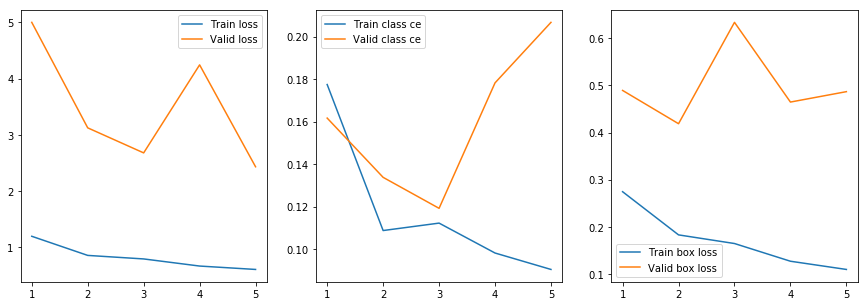

In [26]:
# Plot the history
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()
figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('small_data_small_model'), datetime.datetime.now())
fig.savefig(os.path.join(sdsm,figname),figdpi = 600)
plt.close()

### IV. Validation

In [27]:
# Print the best epoch
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 5 2.434068888425827


In [29]:
# This is the path of the best model in the run 
model_path = os.path.join(models_working_DIR,'pneumonia20190312T2321','mask_rcnn_pneumonia_0005.h5')
shutil.copy(model_path, sdsm)


'/home/ubuntu/healthcare/pneumonia_lungfish/ocean_assets/models/small_data_samll_model/mask_rcnn_pneumonia_0005.h5'

In [30]:
# Copy the best model weights to sdsm directory and rename it with date and time 
os.chdir(sdsm)
os.rename('mask_rcnn_pneumonia_0005.h5', 'pneumonia20190312T2321_mask_rcnn_pneumonia_0005.h5')
best_model= os.path.join(sdsm,'pneumonia20190312T2321_mask_rcnn_pneumonia_0005.h5')

In [31]:
# Setting of inference mode
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=best_model)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190312T2321/mask_rcnn_pneumonia_0005.h5
Re-starting from epoch 5


In [32]:
# Set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

12

*** No instances to display *** 

19

*** No instances to display *** 

47

*** No instances to display *** 

2

*** No instances to display *** 

21
20


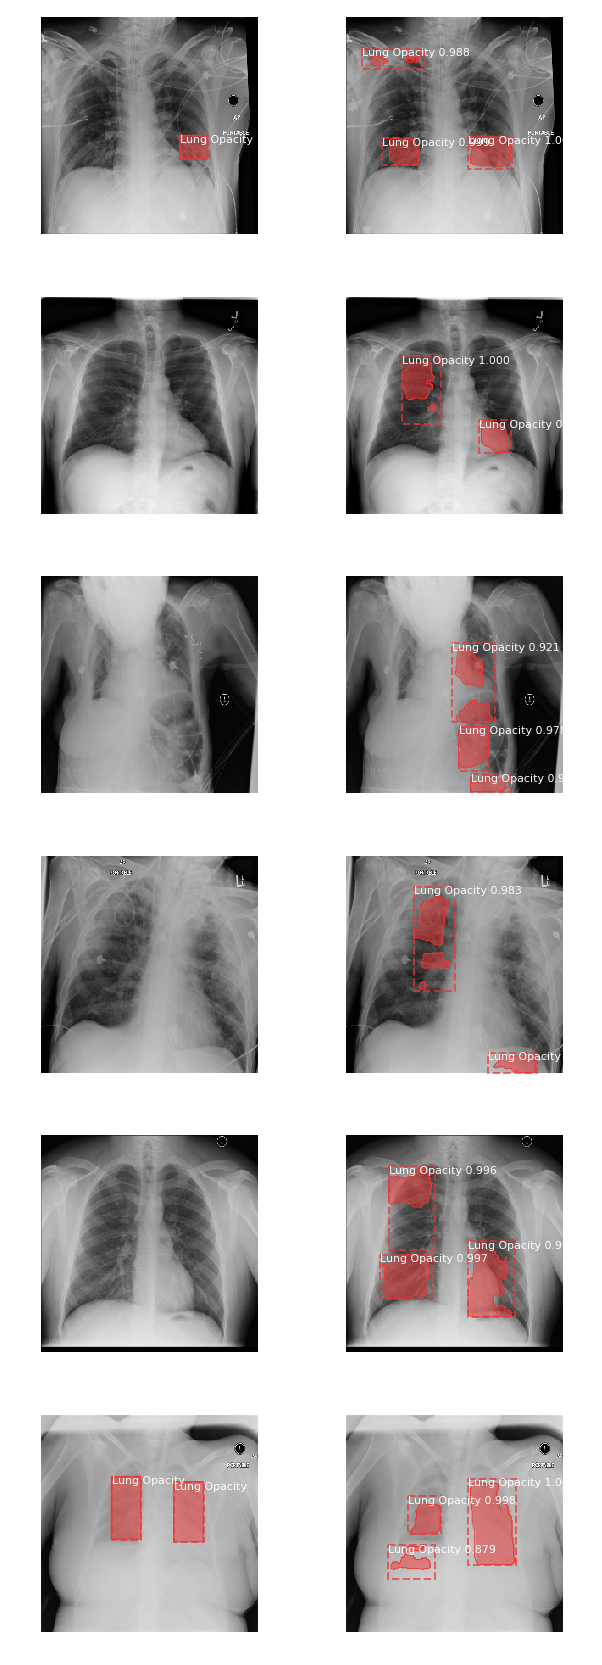

In [37]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_validate
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_validate, inference_config, 
                               image_id, use_mini_mask=False)
    
    #print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, #verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
    print(image_id)
    
    

In [38]:
# Save the plot
figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('small_data_small_inference6_'), datetime.datetime.now())
fig.savefig(os.path.join(sdsm,figname),figdpi = 600)
plt.close()

In [33]:
# Make predictions on validation images and write out csv
def predict(image_fps, filepath='validation_result.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")
            

In [92]:
# Name your csv with date and time
filename = '{}{:%Y%m%dT%H%M%S}.csv'.format(('small_data_small_model_validation_'), datetime.datetime.now())
validation_result_fp = os.path.join(sdsm, filename)
print('Inference Result on validation dataset is saved in', validation_result_fp)
predict(image_fps_validate, filepath=validation_result_fp)


100%|██████████| 50/50 [00:06<00:00,  8.67it/s]


In [93]:
# Have a look
output = pd.read_csv(validation_result_fp)
output.head(2)

,patientId,PredictionString
0,90c345aa-be44-4390-9f4f-12d02643560d,1.0 592.0 464.0 256.0 304.0 0.98 224.0 352.0 ...
1,d38c1cbb-cba7-4a7b-8638-14f1f117b5e7,0.99 592.0 528.0 272.0 304.0 0.95 192.0 592.0...
